<img src="Dau.png">

#### MASEF, University Paris-Dauphine 2021:   Bryan Delamour 

## Turbo Charging Monte Carlo

#### Ref: Turbocharging Monte Carlo pricing for the rough Bergomi model
Ryan McCrickerd, Mikko S. Pakkanen

In [2]:
import numpy as np
from cmath import * 
import pickle
import scipy.stats as sps
from ipynb.fs.full.HybridScheme import *
import matplotlib.pyplot as plt
import py_vollib
from py_vollib.ref_python.black_scholes.implied_volatility import implied_volatility 

We consider the orthogonal separation of the rBergomi price process $S_{t}$ into $S_{t}^{1}$ and $S_{t}^{2}$, where


$$
S_{t}^{1}:=\mathcal{E}\left(\rho \int_{0}^{1} \sqrt{V_{u}} \mathrm{~d} W_{u}^{1}\right)_{t}, \quad S_{t}^{2}:=\mathcal{E}\left(\sqrt{1-\rho^{2}} \int_{0}^{1} \sqrt{V_{u}} \mathrm{~d} W_{u}^{2}\right)_{t}
$$

### Mixed estimator

#### Control variate

This separation facilitates our Mixed estimator, which we define using
$$
X=B S\left(\left(1-\rho^{2}\right) \int_{0}^{t} V_{u} \mathrm{~d} u ; S_{t}^{1}, k\right), \quad Y=B S\left(\rho^{2}\left(\hat{Q}_{n}-\int_{0}^{t} V_{u} \mathrm{~d} u\right) ; S_{t}^{1}, k\right)
$$

to consider price estimators $\hat{P}_{n}(k, t)$ of the following form under the rBergomi model
$$
\hat{P}_{n}(k, t):=\frac{1}{n} \sum_{i=1}^{n}\left(X_{i}+\hat{\alpha}_{n} Y_{i}\right)-\hat{\alpha}_{n} \mathbb{E}[Y], \quad \hat{\sigma}_{B S}^{n}(k, t)^{2} t=B S^{-1}\left(\hat{P}_{n}(k, t) ; 1, k\right)
$$

We compute $\hat{\alpha}_{n}$ and $\hat{Q}_{n}$ post-simulation from sampled $X_{i}, Y_{i}$ and $\left(\int_{0}^{t} V_{u} \mathrm{~d} u\right)$, using


$$
\hat{\alpha}_{n}:=-\frac{\sum_{i=1}^{n}\left(X_{i}-\bar{X}_{n}\right)\left(Y_{i}-\bar{Y}_{n}\right)}{\sum_{i=1}^{n}\left(Y_{i}-\bar{Y}_{n}\right)^{2}}, \quad \hat{Q}_{n}:=\sup \left\{\left(\int_{0}^{t} V_{u} \mathrm{~d} u\right)_{i}: i=1, \ldots, n\right\}
$$

#### Antithetic sampling

We draw a path of $W^{1}$ over the interval $[0, t]$, and appeal to the symmetry in distribution of $S_{t}^{1, \pm}$, defined by

\begin{aligned}
S_{t}^{1, \pm} &=\mathcal{E}\left\{\pm \rho \int_{0}^{t} \sqrt{V_{u}^{\pm}} \mathrm{d} W_{u}^{1}\right\}, \quad V_{t}^{\pm}=\xi_{0}(t) \exp \left(-\frac{\eta^{2}}{2} t^{2 \alpha+1}\right)\left(V_{t}^{\circ}\right)^{\pm 1} \\
V_{t}^{\circ} &=\exp \left(\eta W_{t}^{\alpha}\right)
\end{aligned}


In [2]:
def BS_price(S,K,V):
    d1 = ( np.log(S)-np.log(K) + 0.5*V )*(1/np.sqrt(V))
    d2 = d1 - np.sqrt(V)
    p = S*sps.norm.cdf(d1) - K*sps.norm.cdf(d2)
    return(p)

def jackel_iv(P,S0,K,T):
    return (implied_volatility(P, S0, K, T, 0, 'c'))

In [3]:
# Know implied vols 
K = np.exp( np.array([-0.1787,0.0000,0.1041]) )
iv = np.array([0.2961,0.2061,0.1576])

array([0.83635677, 1.        , 1.10971142])

#### Ref: https://github.com/ryanmccrickerd/rough_bergomi/blob/master/notebooks/turbocharged.ipynb

In [4]:
#parameters

disc = 312*4
paths_ = 100 
T = 0.25
a = -0.43
rho = -0.9
S0 = 1 
prices_mixed = np.zeros(len(K))
prices_base = np.zeros(len(K))
iv_pred_mixed = np.zeros(len(K))
iv_pred_base = np.zeros(len(K))
iv_jack_base = np.zeros(len(K))
iv_jack_mixed = np.zeros(len(K))
rB = rBergomi_h(paths = paths_ , N = disc, T = 0.25, H = a + 0.5)
    
#Anthitetic sampling 
dW_ = rB.dW()
dW = np.r_[dW_, -dW_]
    
W_h = rB.W_h(dW)
V = rB.V(0.235**2, 1.9, W_h)
S = rB.S(S0, -0.9, dW, V)
S1 = rB.S1(S0, -0.9, dW, V)

QV = np.cumsum(V, axis = 1)* (1/disc)
QVT = QV[:, -1]

Q = np.max(QVT, axis=0) + 1e-9

ST = S[:, -1]
VT = V[:, -1]

S1T = S1[:,-1]

mat = np.zeros( (paths_, len(K)) )
c = np.zeros( len (K))
    
for k in range(len(K)): #Mixed Estimator  
    X = BS_price(S1T, K[k], (1 - rho**2) * QVT)
    Y = BS_price(S1T, K[k], rho**2 * (Q - QVT))
    eY = BS_price(1., K[k], rho**2 * Q)
    cov_mat = np.cov(X, Y)
    c = - cov_mat[0,1] / cov_mat[1,1]

    mat= X + c * (Y - eY) # Control variate

    prices_mixed[k] = np.mean(mat,axis=0)
    prices_base[k] = np.mean(np.maximum(ST-K[k],0))
    iv_jack_mixed[k] = jackel_iv(prices_mixed[k],1,K[k],0.25)
    iv_jack_base[k] = jackel_iv(prices_base[k],1,K[k],0.25)

### Base estimator vs mixed estimator

#### Using implied volatility solver by Jäckel (2015) 

We can see on the plot below that the mixed estimator (red) allows a more precise estimation of implied volatilities than the base estimator (blue). In green the true implied volatility.

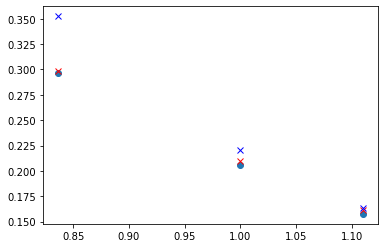

In [5]:
plt.plot(K,iv, 'o')
plt.plot(K,iv_jack_mixed,'x',color='red')
plt.plot(K,iv_jack_base, 'x', color ='blue')